<a href="https://colab.research.google.com/github/ahill132009/Machine-Learning-Course-SPBU/blob/main/Clustering_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import dataset
from google.colab import files; uploaded = files.upload()


Saving spam.csv to spam.csv


In [32]:
from random import sample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from yellowbrick.text import TSNEVisualizer
from IPython.display import Image

import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [7]:
df = pd.read_csv('spam.csv',encoding = "latin1")

In [9]:
df = df.drop(df.columns[2:], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df.label.replace('ham', 0, inplace=True)
df.label.replace('spam', 1, inplace=True)

In [12]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# Обработка текста

def process(row):
  return ' '.join([t.lemma_.lower() for t in nlp(row) if
                   t.lemma_ not in stopwords.words('english') and t.lemma_.isalpha()])

nlp = spacy.load('en')  
df['text'] = df['text'].apply(process)

In [16]:
# Применим TF-IDF векторизацию к тексту СМС

tfidf = TfidfVectorizer(max_features = 5000, use_idf=True) 
tfidf.fit(df.text)
tfidf_vectorized = tfidf.transform(df.text)

In [17]:
# Найдем параметры

parameters={'min_samples':[i for i in np.arange(2,20,2)],
            'eps':[i for i in np.arange(0.1,1.0,0.1)]}

results = {}
for sample in tqdm(parameters['min_samples']):
  for eps_1 in parameters['eps']:
    cluster = DBSCAN(min_samples=sample, eps=eps_1)
    y_pred = cluster.fit_predict(tfidf_vectorized)
    score = silhouette_score(np.asarray(df.label).reshape(-1,1), y_pred)
    results[score] = [sample, eps_1]

res = results[sorted(results, key=lambda k: results[k])[0]]
print('\n')
print('\nThe best parameters are:')
print(f'For min samples: {res[0]}')
print(f'For epsilone: {res[1]}')

100%|██████████| 9/9 [01:10<00:00,  7.82s/it]




The best parameters are:
For min samples: 2
For epsilone: 0.1


In [18]:
cluster = DBSCAN(min_samples=res[0], eps=res[1]) 
y_pred = cluster.fit_predict(tfidf_vectorized)
silhouette_score(tfidf_vectorized, y_pred)

-0.08285694815998992

In [21]:
# Назначим получившийся кластер каждому сэмплу
df['cluster_labels'] = y_pred

-1      4636
 16       38
 17       30
 54       22
 58       12
        ... 
 194       2
 198       2
 202       2
 206       2
 0         2
Name: cluster_labels, Length: 358, dtype: int64

In [ ]:
# Применим алгоритм снижения размерности пространства t-SNE для визуализации

tsne_v = TSNEVisualizer(labels=set(df.cluster_labels).remove(-1))
tsne_v.fit(tfidf_vectorized, df[df.cluster_labels != -1].cluster_labels)


Dataset clusterization


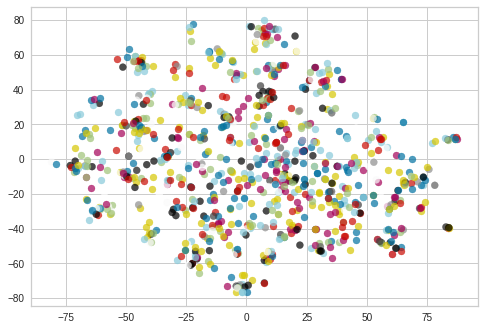

In [34]:
print('Dataset clusterization')
Image('/content/tsne_clusterization.png')

In [38]:
df.cluster_labels.value_counts()

-1      4636
 16       38
 17       30
 54       22
 58       12
        ... 
 194       2
 198       2
 202       2
 206       2
 0         2
Name: cluster_labels, Length: 358, dtype: int64